# Attacking to the Traffic Sign Classifier 

__Objective__: Attack the model. 

__Workflow__:
1.  Load the `Traffic Sign` dataset and examine its structure.
    - Download `tsrd-train` from http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html.
    - Take a closer look at the data inspecting it's size, shape, and quantity.
    - View some random samples using either OpenCV or Matplotlib (or others) of the handwritten digits and observe the complexity of the images. Do you have any issues identify these written numbers?
2. Using `numpy` or other libraries prepare your dataset for training
    - Ensure the format or shape of the data is appropriate for input into your model (one-hot-encoding is needed for the labels)
    - Ensure data types are correct and that data is normalized. 
3. Load model that is trained in the previous project using Keras' `load_model` method
4. Generate malicious inputs
   - Convert Keras model to ART's `KerasClassifier` class
   - FGSM attack
      - Generate malicious inputs based on X_train and FGSM attack using ART's `FastGradientMethod` class with 0.03 epsilon value
      - Generate malicious inputs based on X_train and random uniform noise using `np.random.uniform` with -0.03 and 0.03 (e.g. same epsilon value)
      - Selct first 8 images from test dataset, Plot random 24 images (e.g. 3 rows and 8 columns).
         - First row shows the original images with the predicted labels
         - Second row shows the FGSM based manipulated images with the predicted labels
         - Third row shows the `random uniform` manipulated images with the predicted labels
   - PGD attack
      - Generate malicious inputs based on X_train and FGSM attack using ART's `FastGradientMethod` class with 0.03 epsilon value
      - Generate malicious inputs based on X_train and random uniform noise using `np.random.uniform` with -0.03 and 0.03 (e.g. same epsilon value)
      - Selct first 8 images from test dataset, Plot random 24 images (e.g. 3 rows and 8 columns).
         - First row shows the original images with the predicted labels
         - Second row shows the FGSM based manipulated images with the predicted labels
         - Third row shows the `random uniform` manipulated images with the predicted labels



__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow as you take the `Traffic Sign` dataset, view samples, convert it into the proper shape/format as required by your deep learning library. You are required to train the model using the specifications provided. You should save your model as you'll need it for further analysis in the second milestone.

In [1]:
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent
from keras.models import load_model
from art.estimators.classification import KerasClassifier
import tensorflow as tf
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import cv2
import os
from keras.preprocessing.image import  img_to_array
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

tf.compat.v1.disable_eager_execution()

In [2]:
IMAGE_PATH_TRAIN = '/Users/ozgur/Downloads/tsrd-train/'
COL_NAMES = ['filename','f1','f2','x1','y1','x2','y2','label']
IMAGE_SIZE = (134,128)
EPOCHS = 30
BS = 100
MODEL_NAME = 'cnn-traffic-sign.h5'

In [3]:
# Step 1
model = load_model(MODEL_NAME)

In [4]:
# Step 2: Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0), use_logits=False)

<module 'tensorflow.keras.losses' from '/Users/ozgur/opt/anaconda3/lib/python3.8/site-packages/tensorflow/keras/losses/__init__.py'>


In [5]:
df = pd.read_csv('TsignRecgTrain4170Annotation.txt',names=COL_NAMES,sep=';', index_col=False)

files = glob(IMAGE_PATH_TRAIN + '*.png')
data = []
labels = []

for fname in tqdm(range(len(files)),):
    fname = files[fname]
    image = cv2.imread(fname)
    image = cv2.resize(image, IMAGE_SIZE)
    image = img_to_array(image)
    data.append(image)
    
    label = df.query("filename=='" + os.path.split(fname)[1] + "'").label.values[0]
    labels.append(label)
    
data = np.array(data) / 255.0
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

  0%|          | 0/4170 [00:00<?, ?it/s]

In [6]:
predictions = classifier.predict(testX)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(testY, axis=1)) / len(testY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

/Users/ozgur/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on benign test examples: 99.28057553956835%


In [7]:
# Step 3: Generate adversarial test examples with FGSM attack
ATTACK_POWER = 0.03
attack = FastGradientMethod(estimator=classifier, eps=ATTACK_POWER)
x_test_adv = attack.generate(x=testX)

In [8]:
# Step 4: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(testY, axis=1)) / len(testY)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 42.805755395683455%


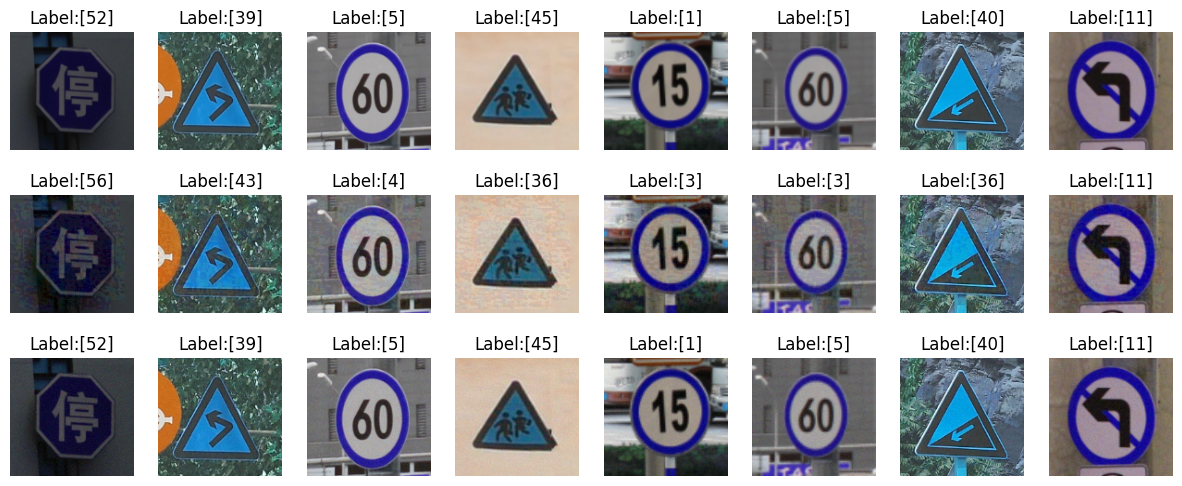

In [9]:
# Step 5: Plot original, noisy and malicious inputs
NUM_OF_ROWS = 3
NUM_OF_COLS = 8
fig, ax = plt.subplots(NUM_OF_ROWS,NUM_OF_COLS, figsize=(15,6))

for i in range(NUM_OF_COLS):
    uniform_noise = np.random.uniform(low=-1.0,high=1.0,size=testX[i].shape) * ATTACK_POWER
    noise = testX[i] + uniform_noise
    
    benign_pred = classifier.predict([testX[i],])
    malicious_pred = classifier.predict([x_test_adv[i],])
    noise_pred = classifier.predict([noise,])

    ax[0,i].imshow(testX[i])
    ax[1,i].imshow(x_test_adv[i])
    ax[2,i].imshow(noise.clip(0.0,1.0))

    ax[0,i].set_title('Label:' + str(benign_pred.argmax(axis=1)))
    ax[1,i].set_title('Label:' + str(malicious_pred.argmax(axis=1)))
    ax[2,i].set_title('Label:' + str(noise_pred.argmax(axis=1)))
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
plt.show()

In [10]:
# Step 6: Generate adversarial test examples with PGD attack
n = 10

attack = ProjectedGradientDescent(classifier, eps=ATTACK_POWER, eps_step=0.01, max_iter=40, targeted=False, 
                                  num_random_init=True)
x_test_adv = attack.generate(x=testX[:n])
y_adv_pred = classifier.predict(x_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(testY[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

PGD - Random Initializations: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Accuracy on first 10 adversarial test samples: 0.000000


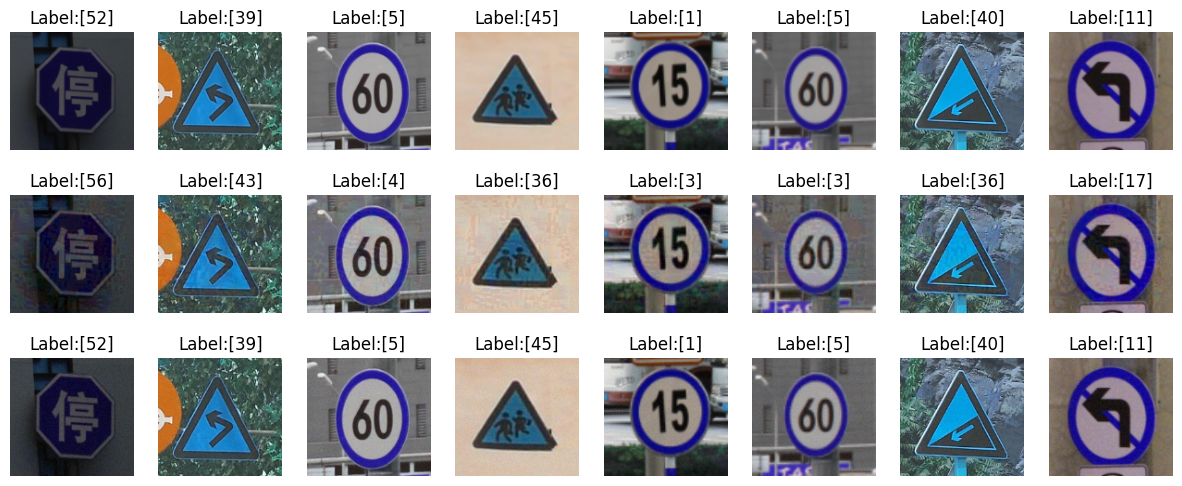

In [11]:
NUM_OF_ROWS = 3
NUM_OF_COLS = 8
fig, ax = plt.subplots(NUM_OF_ROWS,NUM_OF_COLS, figsize=(15,6))

for i in range(NUM_OF_COLS):
    uniform_noise = np.random.uniform(low=-1.0,high=1.0,size=testX[i].shape) * ATTACK_POWER
    noise = testX[i] + uniform_noise
    
    benign_pred = classifier.predict([testX[i],])
    malicious_pred = classifier.predict([x_test_adv[i],])
    noise_pred = classifier.predict([noise,])

    ax[0,i].imshow(testX[i])
    ax[1,i].imshow(x_test_adv[i])
    ax[2,i].imshow(noise.clip(0.0,1.0))

    ax[0,i].set_title('Label:' + str(benign_pred.argmax(axis=1)))
    ax[1,i].set_title('Label:' + str(malicious_pred.argmax(axis=1)))
    ax[2,i].set_title('Label:' + str(noise_pred.argmax(axis=1)))
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
plt.show()